# Multi-Dimensional Scaling
This notebook contains two examples of Multi-Dimensional Scaling (MDS), both from scikit learn.

MDS is a good tool for modelling similarities and dissimilarities between data, and does so by looking at the datas distances in geomaetric space.

First we import the necessary python libraries

In [45]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

Prepare some data based on random data with some noise.

In [46]:
EPSILON = np.finfo(np.float32).eps
n_samples = 20
seed = np.random.RandomState(seed=3)
X_true = seed.randint(0, 20, 2 * n_samples).astype(float)
X_true = X_true.reshape((n_samples, 2))
X_true -= X_true.mean()

similarities = euclidean_distances(X_true)

noise = np.random.rand(n_samples, n_samples)
noise = noise + noise.T
noise[np.arange(noise.shape[0]), np.arange(noise.shape[0])] = 0
similarities += noise

Now we use the MDS and non metrics MDS algorithms on the data in the similarities variable.

In [47]:
mds = manifold.MDS(
    n_components=2,
    max_iter=3000,
    eps=1e-9,
    random_state=seed,
    dissimilarity="precomputed",
    n_jobs=1,
)
pos = mds.fit(similarities).embedding_

nmds = manifold.MDS(
    n_components=2,
    metric=False,
    max_iter=3000,
    eps=1e-12,
    dissimilarity="precomputed",
    random_state=seed,
    n_jobs=1,
    n_init=1,
)
npos = nmds.fit_transform(similarities, init=pos)

pos *= np.sqrt((X_true**2).sum()) / np.sqrt((pos**2).sum())
npos *= np.sqrt((X_true**2).sum()) / np.sqrt((npos**2).sum())

We also rotate the data using Principal Component Analysis (PCA) (I don't know why this step is neccesary though)

In [48]:
clf = PCA(n_components=2)
X_true = clf.fit_transform(X_true)

pos = clf.fit_transform(pos)

npos = clf.fit_transform(npos)

And we can plot the 3 variants, X_true which is the true values, mds and nmds which is the calculated values based on noisy data using metric and non-metric MDS

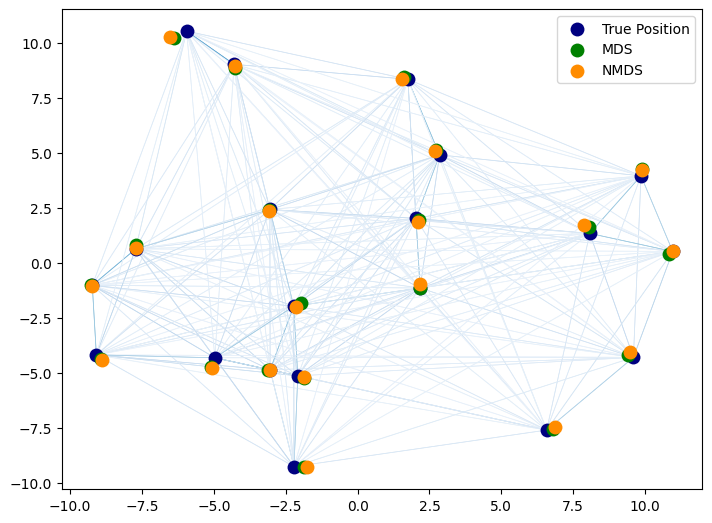

In [49]:
fig = plt.figure(1)
ax = plt.axes([0.0, 0.0, 1.0, 1.0])

s = 100
plt.scatter(X_true[:, 0], X_true[:, 1], color="navy", s=s, lw=0, label="True Position")
plt.scatter(pos[:, 0], pos[:, 1], color="green", s=s, lw=0, label="MDS")
plt.scatter(npos[:, 0], npos[:, 1], color="darkorange", s=s, lw=0, label="NMDS")
plt.legend(scatterpoints=1, loc="best", shadow=False)

similarities = similarities.max() / (similarities + EPSILON) * 100
np.fill_diagonal(similarities, 0)
# Plot the edges
start_idx, end_idx = np.where(pos)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [
    [X_true[i, :], X_true[j, :]] for i in range(len(pos)) for j in range(len(pos))
]
values = np.abs(similarities)
lc = LineCollection(
    segments, zorder=0, cmap=plt.cm.Blues, norm=plt.Normalize(0, values.max())
)
lc.set_array(similarities.flatten())
lc.set_linewidths(np.full(len(segments), 0.5))
ax.add_collection(lc)

plt.show()

## Second dataset
To see it on something that's not just random data, we will see it on some digits as well. It is a similar process, so I skip the explanations here.

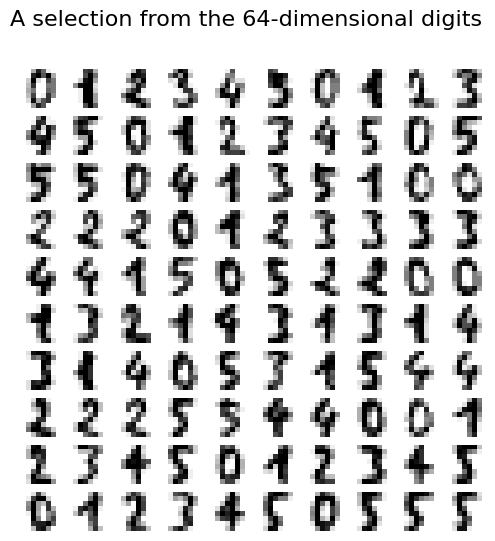

In [50]:
from sklearn.datasets import load_digits
from matplotlib import offsetbox
from sklearn.preprocessing import MinMaxScaler

digits = load_digits(n_class=6)
X, y = digits.data, digits.target
n_samples, n_features = X.shape
n_neighbors = 30


fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("A selection from the 64-dimensional digits", fontsize=16)

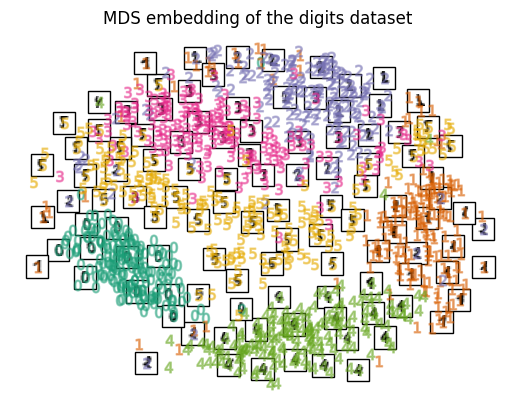

In [51]:
result = manifold.MDS(n_components=2, n_init=1, max_iter=120, n_jobs=2).fit_transform(X, y)

_, ax = plt.subplots()
result = MinMaxScaler().fit_transform(result)

for digit in digits.target_names:
    ax.scatter(
        *result[y == digit].T,
        marker=f"${digit}$",
        s=60,
        color=plt.cm.Dark2(digit),
        alpha=0.425,
        zorder=2,
    )
shown_images = np.array([[1.0, 1.0]])  # just something big
for i in range(X.shape[0]):
    # plot every digit on the embedding
    # show an annotation box for a group of digits
    dist = np.sum((result[i] - shown_images) ** 2, 1)
    if np.min(dist) < 4e-3:
        # don't show points that are too close
        continue
    shown_images = np.concatenate([shown_images, [result[i]]], axis=0)
    imagebox = offsetbox.AnnotationBbox(
        offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), result[i]
    )
    imagebox.set(zorder=1)
    ax.add_artist(imagebox)

ax.set_title("MDS embedding of the digits dataset")
ax.axis("off")

plt.show()

### Sources
https://www.youtube.com/watch?v=GH4QgpK9_Sc (**REALLY good**)

https://towardsdatascience.com/mds-multidimensional-scaling-smart-way-to-reduce-dimensionality-in-python-7c126984e60b

https://stackabuse.com/guide-to-multidimensional-scaling-in-python-with-scikit-learn/

https://scikit-learn.org/stable/auto_examples/manifold/plot_mds.html